# **Travel Recommendation System**

A **travel recommendation system** suggests personalized travel options—such as destinations, hotels, or attractions—based on user preferences, past behavior, and item data. It uses techniques like **content-based filtering**, **collaborative filtering**, or **hybrid models** to generate relevant recommendations. These systems enhance user experience by saving time, improving satisfaction, and increasing engagement for travel platforms.

#### **Objective**
To build a personalized travel recommendation system using the provided datasets, utilizing approaches such as content-based filtering, collaborative filtering, and hybrid models to suggest relevant travel options based on user preferences and behavior.


# Step 1: Import Libraries and Load Data

We'll start by importing necessary libraries and loading the provided datasets into Pandas DataFrames.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# Suppress warnings
warnings.filterwarnings("ignore")


In [2]:
# Load datasets
destinations_df = pd.read_csv("Destinations.csv")
reviews_df = pd.read_csv("Reviews.csv")
userhistory_df = pd.read_csv("UserHistory.csv")
users_df = pd.read_csv("Users.csv")

In [3]:
destinations_df.head()

,DestinationID,DestinationName,State,Type,Popularity,BestTimeToVisit
0,1,Taj Mahal,Uttar Pradesh,Historical,8.691906,Nov-Feb
1,2,Goa Beaches,Goa,Beach,8.605032,Nov-Mar
2,3,Jaipur City,Rajasthan,City,9.225372,Oct-Mar
3,4,Kerala Backwaters,Kerala,Nature,7.977386,Sep-Mar
4,5,Leh Ladakh,Jammu and Kashmir,Adventure,8.399822,Apr-Jun


In [4]:
reviews_df.head()

,ReviewID,DestinationID,UserID,Rating,ReviewText
0,1,178,327,2,Incredible monument!
1,2,411,783,1,Loved the beaches!
2,3,927,12,2,A historical wonder
3,4,358,959,3,Incredible monument!
4,5,989,353,2,Loved the beaches!


In [5]:
userhistory_df.head()

,HistoryID,UserID,DestinationID,VisitDate,ExperienceRating
0,1,525,760,2024-01-01,3
1,2,184,532,2024-02-15,5
2,3,897,786,2024-03-20,2
3,4,470,660,2024-01-01,1
4,5,989,389,2024-02-15,4


In [6]:
users_df.head()

,UserID,TravellerName,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,Kavya,kavya@example.com,"Beaches, Historical",Female,1,0
1,2,Rohan,rohan@example.com,"Nature, Adventure",Male,2,2
2,3,Kavya,kavya@example.com,"City, Historical",Female,2,0
3,4,Anika,anika@example.com,"Beaches, Historical",Female,1,0
4,5,Tanvi,tanvi@example.com,"Nature, Adventure",Female,2,2


In [7]:
users_df.Preferences.unique()

array(['Beaches, Historical', 'Nature, Adventure', 'City, Historical'],
      dtype=object)

In [8]:
# Merge datasets step-by-step
# Step 1: Merge reviews with destinations on 'DestinationID'
reviews_destinations = pd.merge(reviews_df, destinations_df, on='DestinationID', how='inner')

# Step 2: Merge the result with user history on 'UserID'
reviews_destinations_userhistory = pd.merge(reviews_destinations, userhistory_df, on='UserID', how='inner')

# Step 3: Merge the result with users on 'UserID'
df = pd.merge(reviews_destinations_userhistory, users_df, on='UserID', how='inner')

df.head()

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,DestinationName,State,Type,Popularity,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,TravellerName,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544352,Oct-Mar,79,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284127,Nov-Feb,834,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.738761,Oct-Mar,998,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1
3,5,989,353,2,Loved the beaches!,Kerala Backwaters,Kerala,Nature,8.208088,Sep-Mar,202,894,2024-01-01,5,Isha,isha@example.com,"Nature, Adventure",Female,2,0
4,6,473,408,4,A historical wonder,Jaipur City,Rajasthan,City,8.138558,Oct-Mar,331,403,2024-01-01,2,Ishaan,ishaan@example.com,"City, Historical",Male,2,0


## **Data Preprocessing**

We will clean and preprocess the data to make it ready for building recommendation models.

In [9]:
df.drop_duplicates(inplace=True)
df.shape

(993, 20)

In [10]:
df.columns

Index(['ReviewID', 'DestinationID_x', 'UserID', 'Rating', 'ReviewText',
       'DestinationName', 'State', 'Type', 'Popularity', 'BestTimeToVisit',
       'HistoryID', 'DestinationID_y', 'VisitDate', 'ExperienceRating',
       'TravellerName', 'Email', 'Preferences', 'Gender', 'NumberOfAdults',
       'NumberOfChildren'],
      dtype='object')

In [11]:
df.DestinationName.unique()

array(['Jaipur City', 'Taj Mahal', 'Kerala Backwaters', 'Goa Beaches',
       'Leh Ladakh'], dtype=object)

In [12]:
df.to_csv("Travel_Data.csv",index=False)

## **Exploratory Data Analysis**

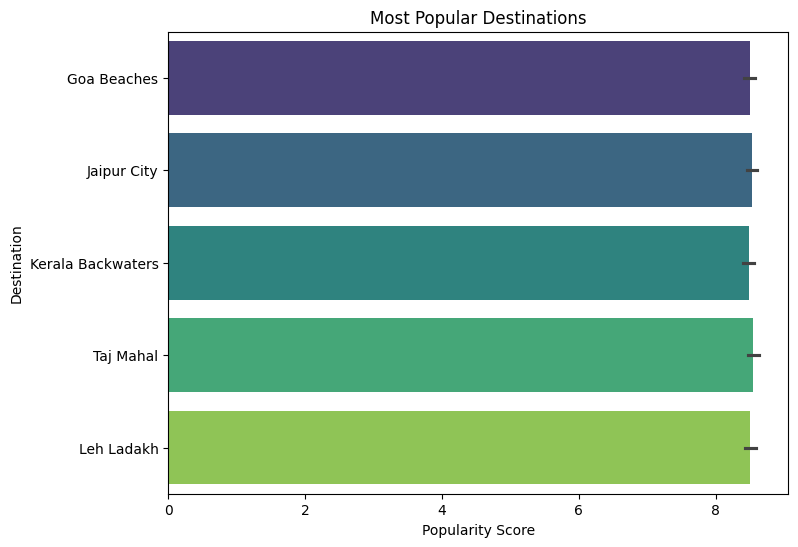

In [13]:
# 1. Destination Popularity
plt.figure(figsize=(8, 6))
sns.barplot(x='Popularity', y='DestinationName', data=destinations_df.sort_values(by='Popularity', ascending=False),
            hue='DestinationName',palette='viridis',dodge=False,legend=False)

plt.title('Most Popular Destinations')
plt.xlabel('Popularity Score')
plt.ylabel('Destination')
plt.show()

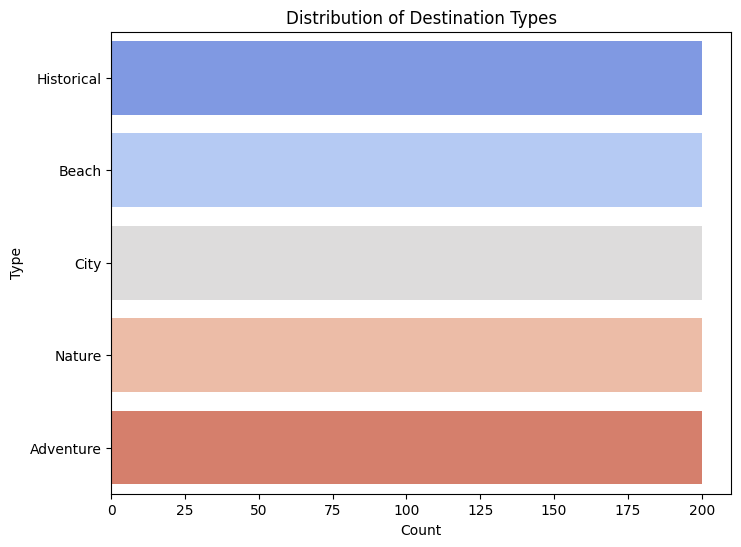

In [14]:
# 2. Destination Types Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='Type', data=destinations_df, order=destinations_df['Type'].value_counts().index, palette='coolwarm',
              hue='Type',dodge=False,legend=False )
plt.title('Distribution of Destination Types')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

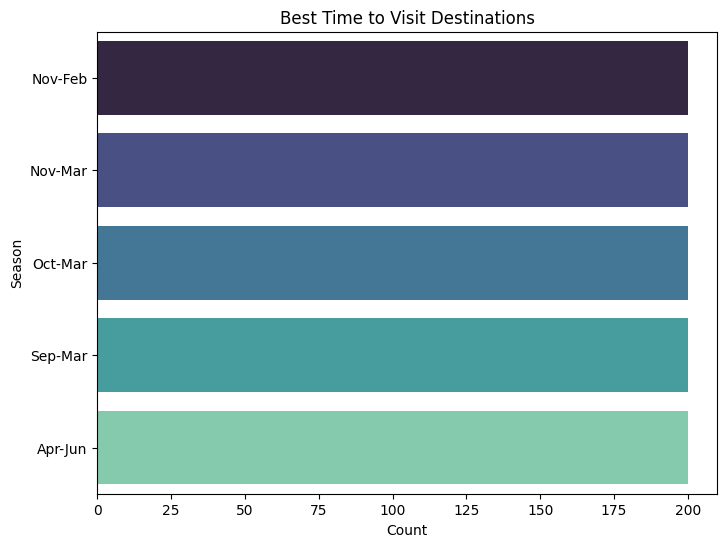

In [15]:
# 3. Best Time to Visit Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='BestTimeToVisit', data=destinations_df, order=destinations_df['BestTimeToVisit'].value_counts().index, palette='mako',
            hue = 'BestTimeToVisit')
plt.title('Best Time to Visit Destinations')
plt.xlabel('Count')
plt.ylabel('Season')
plt.show()

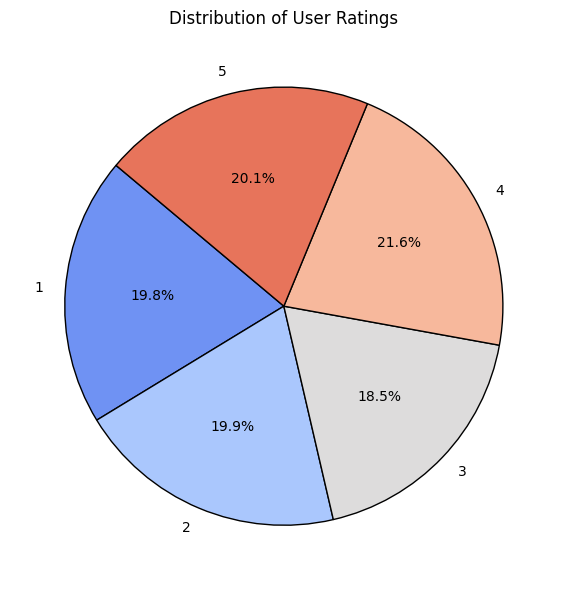

In [16]:
# Rating Distribution
rating_counts = reviews_df['Rating'].value_counts().sort_index()

# Generate colors from coolwarm palette based on number of unique ratings
colors = sns.color_palette("coolwarm", len(rating_counts))

plt.figure(figsize=(8, 6))
plt.pie(
    rating_counts,
    labels=rating_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Distribution of User Ratings')
plt.tight_layout()
plt.show()

## **Content-Based Recommendation Model**

Content-based recommendations **recommend destinations based on the attributes of the destination wrt user preferences**

(i.e., based on the "Preferences" and "Type" columns).

### Step 3.1: Prepare the Destination Features
We'll use the "Type", "State", and "BestTimeToVisit" columns to create features for content-based filtering.

In [17]:
# Create a text-based feature for the destinations
df['features'] = df['Type'] + ' ' + df['State'] + ' ' + df['BestTimeToVisit'] + " " + df['Preferences']

# Apply TF-IDF vectorizer to create feature vectors for destinations
vectorizer = TfidfVectorizer(stop_words='english')
destination_features = vectorizer.fit_transform(df['features'])

# Compute cosine similarity between destinations
cosine_sim = cosine_similarity(destination_features, destination_features)

### Step 3.2: Recommendation Function

Based on the cosine similarity matrix, we can recommend destinations similar to the ones the user has liked in the past.

In [18]:
# Function to recommend destinations for a user based on similarity scores.

def recommend_destinations(user_id, userhistory_df, destinations_df, cosine_sim, top_n=5):
    """
    Recommend top N destinations for a user based on similarity scores.

    Parameters:
    - user_id (int): ID of the user.
    - userhistory_df (pd.DataFrame): User travel history with columns ['UserID', 'DestinationID'].
    - destinations_df (pd.DataFrame): Destination details.
    - cosine_sim (np.array): Cosine similarity matrix between destinations.
    - top_n (int): Number of recommendations to return (default 5).

    Returns:
    - pd.DataFrame: Recommended destinations with relevant details.
    """
    # Find destinations visited by the user
    visited = userhistory_df[userhistory_df['UserID'] == user_id]['DestinationID'].values

    if len(visited) == 0:
        print(f"User {user_id} has no visited destinations in the history.")
        return pd.DataFrame()

    # Sum similarity scores for all visited destinations
    # Assuming DestinationID starts at 1 and matches cosine_sim indexing
    similarity_scores = np.sum(cosine_sim[visited - 1], axis=0)

    # Sort destinations by descending similarity score
    sorted_indices = np.argsort(similarity_scores)[::-1]

    recommendations = []
    for idx in sorted_indices:
        dest_id = destinations_df.iloc[idx]['DestinationID']
        if dest_id not in visited:
            recommendations.append(destinations_df.iloc[idx][[
                'DestinationID', 'DestinationName', 'State', 'Type', 'Popularity', 'BestTimeToVisit'
            ]].to_dict())
        if len(recommendations) == top_n:
            break

    if not recommendations:
        print(f"No new destinations to recommend for user {user_id}.")
        return pd.DataFrame()

    rec_df = pd.DataFrame(recommendations)
    rec_df.rename(columns={'Type': 'Category','State': 'Location','Popularity': 'Popularity Score'}, inplace=True)
    rec_df['Popularity Score'] = rec_df['Popularity Score'].round(3)
    # Sort by Popularity Score descending
    rec_df = rec_df.sort_values(by='Popularity Score', ascending=False).reset_index(drop=True)
    print(f"Top {top_n} recommended destinations for user {user_id}:\n")
    return rec_df.reset_index(drop=True)

In [19]:
# Usage Example:
recommended_destinations = recommend_destinations(11, userhistory_df, destinations_df, cosine_sim)
recommended_destinations

Top 5 recommended destinations for user 11:



,DestinationID,DestinationName,Location,Category,Popularity Score,BestTimeToVisit
0,404,Kerala Backwaters,Kerala,Nature,9.289,Sep-Mar
1,405,Leh Ladakh,Jammu and Kashmir,Adventure,8.266,Apr-Jun
2,202,Goa Beaches,Goa,Beach,8.247,Nov-Mar
3,992,Goa Beaches,Goa,Beach,8.115,Nov-Mar
4,201,Taj Mahal,Uttar Pradesh,Historical,7.654,Nov-Feb


In [20]:
# Usage Example
recommended_destinations = recommend_destinations(7, userhistory_df, destinations_df, cosine_sim)
recommended_destinations

Top 5 recommended destinations for user 7:



,DestinationID,DestinationName,Location,Category,Popularity Score,BestTimeToVisit
0,40,Leh Ladakh,Jammu and Kashmir,Adventure,9.451,Apr-Jun
1,962,Goa Beaches,Goa,Beach,9.211,Nov-Mar
2,964,Kerala Backwaters,Kerala,Nature,8.862,Sep-Mar
3,963,Jaipur City,Rajasthan,City,8.814,Oct-Mar
4,90,Leh Ladakh,Jammu and Kashmir,Adventure,7.865,Apr-Jun


## **Collaborative Filtering Based Recommendation Model**
In collaborative filtering, we **recommend destinations based on the behavior and preferences of other similar users.**

#### Step 4.1: Create a User-Item Matrix
We'll create a matrix where rows represent users, and columns represent destinations. The values will represent the ratings or experience of the user for each destination.

In [21]:
# Create a user-item matrix based on user history
user_item_matrix = userhistory_df.pivot(index='UserID', columns='DestinationID', values='ExperienceRating')

# Fill missing values with 0 (indicating no rating/experience)
user_item_matrix.fillna(0, inplace=True)

# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

### Step 4.2: Cosine Similarity Between Users
We will compute the cosine similarity between users based on the user-item matrix

In [22]:
# Function to recommend destinations based on user similarity

def collaborative_recommend(user_id, user_similarity, user_item_matrix, destinations_df, top_n=5):
    """
    Recommend top N destinations for a user based on collaborative filtering.

    Parameters:
    - user_id (int): ID of the user for whom recommendations are made.
    - user_similarity (np.array): User-user similarity matrix.
    - user_item_matrix (pd.DataFrame): User-item interaction matrix (e.g., ratings).
    - destinations_df (pd.DataFrame): Destination details.
    - top_n (int): Number of recommendations to return (default 5).

    Returns:
    - pd.DataFrame: Recommended destinations with user-friendly details, sorted by Popularity Score.
    """
    # Validate user_id
    if user_id - 1 not in range(user_similarity.shape[0]):
        print(f"User ID {user_id} is out of bounds.")
        return pd.DataFrame()

    # Get similarity scores for all users relative to the given user
    similarity_scores = user_similarity[user_id - 1]

    # Find top N similar users excluding the user itself (assumed at position user_id-1)
    similar_users_idx = np.argsort(similarity_scores)[::-1]
    similar_users_idx = similar_users_idx[similar_users_idx != (user_id - 1)][:top_n]

    if len(similar_users_idx) == 0:
        print(f"No similar users found for user {user_id}.")
        return pd.DataFrame()

    # Average the ratings/preferences of similar users to get recommendation scores
    avg_ratings = user_item_matrix.iloc[similar_users_idx].mean(axis=0)

    # Select top N destinations with highest average rating
    top_destinations = avg_ratings.sort_values(ascending=False).head(top_n).index

    # Get detailed info for these destinations
    recommendations = destinations_df[destinations_df['DestinationID'].isin(top_destinations)][[
        'DestinationID', 'DestinationName', 'State', 'Type', 'Popularity', 'BestTimeToVisit'
    ]].copy()

    if recommendations.empty:
        print(f"No destination recommendations available for user {user_id}.")
        return pd.DataFrame()

    # Rename columns for user-friendliness
    recommendations.rename(columns={'DestinationName': 'DestinationName','State': 'Location',
        'Type': 'Category','Popularity': 'Popularity Score' }, inplace=True)

    # Round popularity to 3 decimals
    recommendations['Popularity Score'] = recommendations['Popularity Score'].round(3)

    # Sort by Popularity Score descending and reset index
    recommendations = recommendations.sort_values(by='Popularity Score', ascending=False).reset_index(drop=True)

    print(f"Top {top_n} recommendations for user {user_id}:\n")
    return recommendations

In [23]:
# Usage Example
collaborative_recommendations = collaborative_recommend(1, user_similarity, user_item_matrix, destinations_df)
collaborative_recommendations

Top 5 recommendations for user 1:



,DestinationID,DestinationName,Location,Category,Popularity Score,BestTimeToVisit
0,785,Leh Ladakh,Jammu and Kashmir,Adventure,9.367,Apr-Jun
1,520,Leh Ladakh,Jammu and Kashmir,Adventure,8.522,Apr-Jun
2,347,Goa Beaches,Goa,Beach,7.921,Nov-Mar
3,6,Taj Mahal,Uttar Pradesh,Historical,7.649,Nov-Feb
4,685,Leh Ladakh,Jammu and Kashmir,Adventure,7.599,Apr-Jun


In [24]:
# Usage Example
collaborative_recommendations = collaborative_recommend(11, user_similarity, user_item_matrix, destinations_df)
collaborative_recommendations

Top 5 recommendations for user 11:



,DestinationID,DestinationName,Location,Category,Popularity Score,BestTimeToVisit
0,970,Leh Ladakh,Jammu and Kashmir,Adventure,9.013,Apr-Jun
1,301,Taj Mahal,Uttar Pradesh,Historical,8.634,Nov-Feb
2,368,Jaipur City,Rajasthan,City,8.008,Oct-Mar
3,347,Goa Beaches,Goa,Beach,7.921,Nov-Mar
4,436,Taj Mahal,Uttar Pradesh,Historical,7.728,Nov-Feb


## **User Input Based Recommendation System**

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess the data
data = pd.read_csv('Travel_Data.csv')

In [26]:
data.rename(columns={'Type': 'Category', 'Popularity': 'PopularityScore'}, inplace=True)
data['PopularityScore'] = data['PopularityScore'].round(3)

In [27]:
data.head(3)

,ReviewID,DestinationID_x,UserID,Rating,ReviewText,DestinationName,State,Category,PopularityScore,BestTimeToVisit,HistoryID,DestinationID_y,VisitDate,ExperienceRating,TravellerName,Email,Preferences,Gender,NumberOfAdults,NumberOfChildren
0,1,178,327,2,Incredible monument!,Jaipur City,Rajasthan,City,8.544,Oct-Mar,79,175,2024-01-01,3,Pooja,pooja@example.com,"City, Historical",Female,1,1
1,2,411,783,1,Loved the beaches!,Taj Mahal,Uttar Pradesh,Historical,8.284,Nov-Feb,834,894,2024-03-20,2,Karan,karan@example.com,"City, Historical",Male,1,1
2,4,358,959,3,Incredible monument!,Jaipur City,Rajasthan,City,7.739,Oct-Mar,998,660,2024-02-15,4,Ritvik,ritvik@example.com,"Nature, Adventure",Male,1,1


In [28]:
# Select relevant features
features = ['DestinationName', 'State', 'Category', 'BestTimeToVisit', 'Preferences', 'Gender', 'NumberOfAdults', 'NumberOfChildren']
target = 'PopularityScore'  # Predicting popularity

# Encode categorical variables
label_encoders = {}
for col in features:
    if data[col].dtype == 'object':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        label_encoders[col] = le

# Split the dataset
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


Mean Squared Error: 0.30
R² Score: 0.07


In [29]:
# Prediction system
def recommend_destinations(user_input, model, label_encoders, features, data):
    # Encode user input
    encoded_input = {}
    for feature in features:
        if feature in label_encoders:
            encoded_input[feature] = label_encoders[feature].transform([user_input[feature]])[0]
        else:
            encoded_input[feature] = user_input[feature]

    # Convert to DataFrame
    input_df = pd.DataFrame([encoded_input])
    # Predict popularity
    predicted_popularity = model.predict(input_df)[0]
    return predicted_popularity

In [30]:
# Example user input
user_input = {
    'DestinationName': 'Jaipur City',
    'Category': 'City',
    'State': 'Rajasthan',
    'BestTimeToVisit': 'Oct-Mar',
    'Preferences': 'City, Historical',
    'Gender': 'Female',
    'NumberOfAdults': 2,
    'NumberOfChildren': 1,
}

# Make a prediction
predicted_popularity = recommend_destinations(user_input, model, label_encoders, features, data)

# Print the predicted popularity and the recommended destination details
print(f"Predicted Popularity Score: {predicted_popularity:.2f}")

Predicted Popularity Score: 7.88


In [31]:
# ! pip install ipywidgets

In [32]:
import ipywidgets as widgets
from IPython.display import display, clear_output

def get_user_input_and_predict(model, label_encoders, features, data):
    # Dropdowns and inputs
    destination_dropdown = widgets.Dropdown(
        options=['Jaipur City', 'Taj Mahal', 'Kerala Backwaters', 'Goa Beaches', 'Leh Ladakh'],
        description='Destination:'
    )

    category_dropdown = widgets.Dropdown(
        options=['City', 'Historical', 'Beach', 'Nature', 'Adventure'],
        description='Category:'
    )

    state_dropdown = widgets.Dropdown(
        options=['Rajasthan', 'Uttar Pradesh', 'Kerala', 'Goa', 'Ladakh'],
        description='State:'
    )

    best_time_dropdown = widgets.Dropdown(
        options=['Oct-Mar', 'Nov-Feb', 'Dec-May', 'Apr-Jun', 'May-Sep'],
        description='Best Time:'
    )

    # Preferences as select buttons
    preferences_buttons = widgets.RadioButtons(
    options=['Beaches, Historical', 'Nature, Adventure', 'City, Historical'],
    description='Preferences:',
    layout=widgets.Layout(display='flex', flex_flow='row', align_items='center'),
    style={'description_width': 'initial'}

    )

    gender_dropdown = widgets.Dropdown(
        options=['Male', 'Female', 'Other'],
        description='Gender:'
    )

    adults_slider = widgets.IntSlider(value=2, min=1, max=10, step=1, description='Adults:')
    children_slider = widgets.IntSlider(value=0, min=0, max=10, step=1, description='Children:')

    submit_button = widgets.Button(description="Submit", button_style='success')

    # Output area
    output = widgets.Output()

    # Submit handler
    def on_submit(b):
        with output:
            clear_output()
            # Collect user input
            user_input = {
                'DestinationName': destination_dropdown.value,
                'Category': category_dropdown.value,
                'State': state_dropdown.value,
                'BestTimeToVisit': best_time_dropdown.value,
                'Preferences': preferences_buttons.value,
                'Gender': gender_dropdown.value,
                'NumberOfAdults': adults_slider.value,
                'NumberOfChildren': children_slider.value,
            }

            # Make prediction
            try:
                predicted_popularity = recommend_destinations(user_input, model, label_encoders, features, data)
                print(f"\n📈 Predicted Popularity Score: {predicted_popularity:.2f}")
            except Exception as e:
                print("⚠️ Error in prediction:", str(e))

    # Bind submit button
    submit_button.on_click(on_submit)

    # Display all widgets
    display(destination_dropdown, category_dropdown, state_dropdown, best_time_dropdown,
            preferences_buttons, gender_dropdown, adults_slider, children_slider, submit_button, output)


In [33]:
get_user_input_and_predict(model, label_encoders, features, data)

Dropdown(description='Destination:', options=('Jaipur City', 'Taj Mahal', 'Kerala Backwaters', 'Goa Beaches', …

Dropdown(description='Category:', options=('City', 'Historical', 'Beach', 'Nature', 'Adventure'), value='City'…

Dropdown(description='State:', options=('Rajasthan', 'Uttar Pradesh', 'Kerala', 'Goa', 'Ladakh'), value='Rajas…

Dropdown(description='Best Time:', options=('Oct-Mar', 'Nov-Feb', 'Dec-May', 'Apr-Jun', 'May-Sep'), value='Oct…

RadioButtons(description='Preferences:', layout=Layout(align_items='center', display='flex', flex_flow='row'),…

Dropdown(description='Gender:', options=('Male', 'Female', 'Other'), value='Male')

IntSlider(value=2, description='Adults:', max=10, min=1)

IntSlider(value=0, description='Children:', max=10)

Button(button_style='success', description='Submit', style=ButtonStyle())

Output()

In [34]:
import pickle

pickle.dump(model, open("model.pkl",'wb'))
pickle.dump(label_encoders, open("label_encoders.pkl",'wb'))